# NuScenes

- Tutorial: <https://www.nuscenes.org/nuscenes?tutorial=nuscenes>

In [1]:
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.388 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [14]:
import concurrent.futures
import itertools
import numpy as np
from PIL import Image

def process_sample(sample):        
    cams = [
        'CAM_FRONT', 
        'CAM_FRONT_LEFT', 
        'CAM_FRONT_RIGHT', 
        'CAM_BACK', 
        'CAM_BACK_LEFT', 
        'CAM_BACK_RIGHT'
    ]
    data = []
    for cam in cams:
        image_path, boxes, _ = nusc.get_sample_data(sample['data'][cam])
        data.append((image_path, boxes))
    return data

def get_cam_data(scene):
    sample_token = scene['first_sample_token']
    last_sample_token = scene['last_sample_token']
    samples = []
    while sample_token != last_sample_token:
        samples.append(nusc.get('sample', sample_token))
        sample_token = samples[-1]['next']

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(process_sample, samples)

    return list(itertools.chain(*results))  

def compute(image_path, boxes):
    image = np.asarray(Image.open(image_path).resize((512, 512)))
    boxes = [(box.name, box.center, box.wlh) for box in boxes]
    return image, boxes

def dataset(scene, batch_size=64):
    data = get_cam_data(scene)
    i = 0
    while i < len(data):
        batch = data[i : i + batch_size]
        yield [compute(i, b) for i, b in batch]
        i += batch_size

In [15]:
ds = dataset(nusc.scene[0])

In [16]:
len(next(ds))

64

In [17]:
ip, boxes = next(ds)[1]
ip.shape

(512, 512, 3)

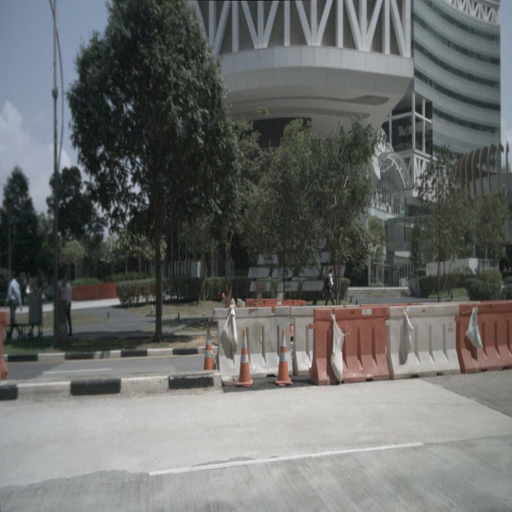

In [18]:
Image.fromarray(ip)

In [19]:
from functools import partial
import optax
import jax.numpy as jnp
from flax import nnx
import jax

In [20]:
from resnet import Resnet, resnet_spec

rngs = nnx.Rngs(0)
model = Resnet(*resnet_spec[101], 80, rngs=rngs)

In [21]:
model(ip.reshape(1, *ip.shape))

TypeError: add got incompatible shapes for broadcasting: (1, 255, 64, 256), (1, 255, 127, 256).